<a href="https://colab.research.google.com/github/Mohammdamin-Sedaghat/stockML/blob/Aviral/AAPL_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

aviralgupta78_aapl_data_1_path = kagglehub.dataset_download('aviralgupta78/aapl-data-1')

print('Data source import complete.')


/tmp/ipykernel_30/2978413473.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  AAPL_data_resampled = AAPL_data.resample('5T').mean()  # '5T' for 5-minute intervals
/tmp/ipykernel_30/2978413473.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  AAPL_data_resampled.fillna(method='ffill', inplace=True)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 871s 332ms/step - loss: 3.2864e-04 - val_loss: 0.0026
Epoch 3/20
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 886s 337ms/step - loss: 1.9311e-04 - val_loss: 0.0018
Epoch 4/20
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 864s 329ms/step - loss: 1.8446e-04 - val_loss: 7.3035e-04
Epoch 5/20
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 880s 335ms/step - loss: 1.8358e-04 - val_loss: 4.8303e-04
Epoch 6/20
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 865s 329ms/step - loss: 1.8061e-04 - val_loss: 6.2605e-04
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 132s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted next-day return for AAPL: 221.0599


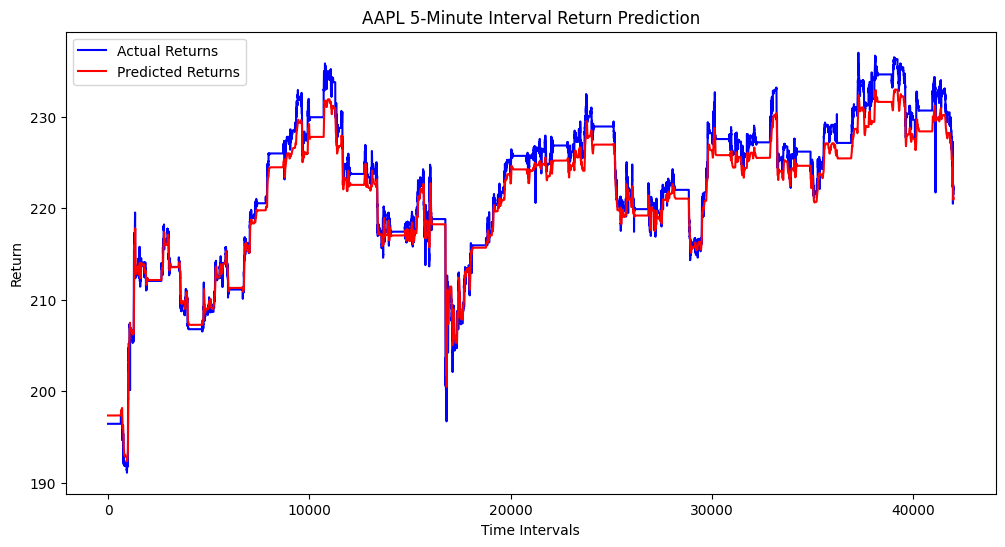

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# Load data
AAPL_data = pd.read_csv('/kaggle/input/aapl-data-1/AAPL_data_1.csv', parse_dates=['timestamp'])

# Resample data to 5 min intervals
AAPL_data.set_index('timestamp', inplace=True)  # Make timestamp the index
AAPL_data_resampled = AAPL_data.resample('5T').mean()  # '5T' for 5-minute intervals
AAPL_data_resampled.fillna(method='ffill', inplace=True)

# Normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(AAPL_data_resampled[['close']])

# Preparing data for LSTM
window_size = 390  # 1 week of data in 5 min intervals

X, y = [], []

# Prepare the data for LSTM (supervised learning)
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])  # Using last 390 intervals as input
    y.append(scaled_data[i, 0])  # Predicting the 'close' price (index 3)

X, y = np.array(X), np.array(y)

# Split into training and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting the 'close' price

model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to try and avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions on test data
predicted_returns = model.predict(X_test)

# Inverse transform predictions and actual values to interpret returns
predicted_returns_rescaled = scaler.inverse_transform(
    np.concatenate((np.zeros((len(predicted_returns), X.shape[2] - 1)), predicted_returns), axis=1))[:, 0]
actual_returns_rescaled = scaler.inverse_transform(
    np.concatenate((np.zeros((len(y_test), X.shape[2] - 1)), y_test.reshape(-1, 1)), axis=1))[:, 0]

# Predict the next 5-min interval stock price based on the last available sequence
last_sequence = X_test[-1].reshape((1, X_test.shape[1], X_test.shape[2]))
predicted_next_day_return = model.predict(last_sequence)
predicted_next_day_return_rescaled = scaler.inverse_transform(
    np.concatenate((np.zeros((1, X.shape[2] - 1)), predicted_next_day_return), axis=1))[:, 0][0]

# Display the predicted next-day return
print(f"Predicted next-day return for AAPL: {predicted_next_day_return_rescaled:.4f}")

# For predicted vs actual visaualization
plt.figure(figsize=(12, 6))
plt.plot(actual_returns_rescaled, color='blue', label='Actual Returns')
plt.plot(predicted_returns_rescaled, color='red', label='Predicted Returns')
plt.title('AAPL 5-Minute Interval Return Prediction')
plt.xlabel('Time Intervals')
plt.ylabel('Return')
plt.legend()
plt.show()

There were a couple of problems with the code above. Firstly, the training ended very early and based on the graph for visualization it seems like the model may have overfit. Also, the code above predicts the next 5 inute interval price and not the next day closing price.

Another attempt was made to try and predict a weeks worth of closing prices.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# Load data
AAPL_data = pd.read_csv('/kaggle/input/aapl-data-1/AAPL_data_1.csv', parse_dates=['timestamp'])

# Resample data to 5-minute intervals
AAPL_data.set_index('timestamp', inplace=True)  # Make timestamp the index
AAPL_data_resampled = AAPL_data.resample('5T').mean()  # '5T' for 5-minute intervals
AAPL_data_resampled.fillna(method='ffill', inplace=True)

# Normalizing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(AAPL_data_resampled[['close']])

# Prepare the dataset for LSTM (using 390 intervals for 1 week)
window_size = 390  # 1 week of data (5-minute intervals)
forecast_horizon = 390  # Predicting 1 week ahead

X, y = [], []

# Prepare the data for supervised learning (LSTM)
for i in range(window_size, len(scaled_data) - forecast_horizon + 1):
    X.append(scaled_data[i - window_size:i, :])  # Using last 390 intervals as input
    y.append(scaled_data[i:i + forecast_horizon, 0])  # Predicting the next 390 intervals

X, y = np.array(X), np.array(y)

# Split into training and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=30))
model.add(Dropout(0.3))
model.add(Dense(units=forecast_horizon))  # Outputting a week’s worth of predictions

model.compile(optimizer='adam', loss='mean_squared_error')

# Defining early stoppiing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions
predicted_returns = model.predict(X_test)

# Inverse transform predictions and actual values to interpret returns
predicted_returns_reshaped = predicted_returns.reshape(-1, 1)  # Flatten predictions
y_test_reshaped = y_test.reshape(-1, 1)  # Flatten actual returns

# Apply inverse transformation
predicted_returns_rescaled = scaler.inverse_transform(predicted_returns_reshaped).reshape(predicted_returns.shape)
actual_returns_rescaled = scaler.inverse_transform(y_test_reshaped).reshape(y_test.shape)
# Predict the next week's stock price based on the last available sequence
last_sequence = X_test[-1].reshape((1, X_test.shape[1], X_test.shape[2]))
predicted_next_week_return = model.predict(last_sequence)
predicted_next_week_return_rescaled = scaler.inverse_transform(
    np.concatenate((np.zeros((1, X.shape[2] - 1)), predicted_next_week_return), axis=1))[:, 0]

# Display the predicted next-week return
print("Predicted next week return for AAPL:")
print(predicted_next_week_return_rescaled)

# Visualize predicted vs actual returns for the last sequence in the test set
plt.figure(figsize=(12, 6))
plt.plot(actual_returns_rescaled[-1], color='blue', label='Actual Returns')
plt.plot(predicted_returns_rescaled[-1], color='red', label='Predicted Returns')
plt.title('AAPL 5-Minute Interval Return Prediction for 1 Week')
plt.xlabel('Intervals (5-minute)')
plt.ylabel('Return')
plt.legend()
plt.show()

This model was also overfit. I then plot the training vs validation loss and the fact

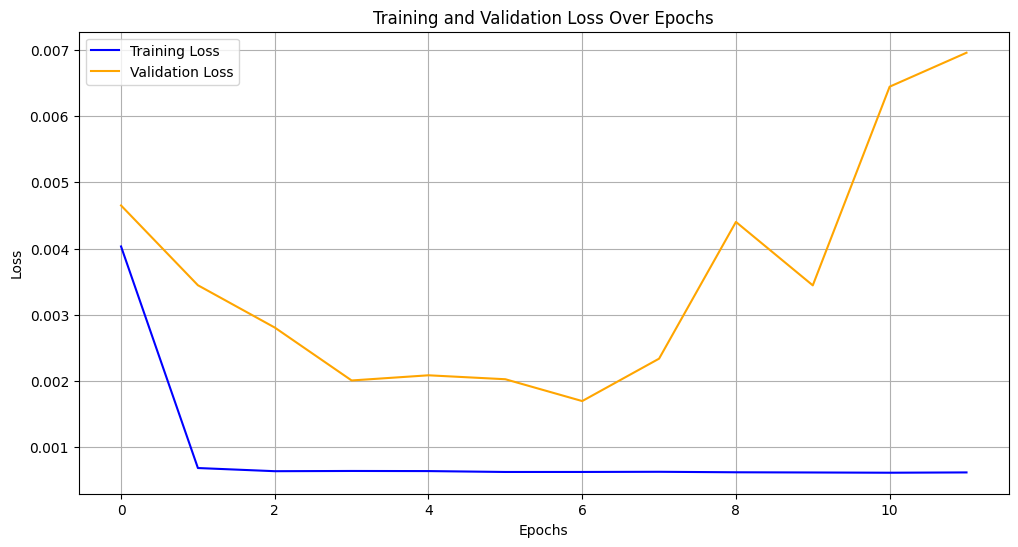

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()